In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from qiskit_aer import Aer
from qiskit import *
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.classifiers import VQC

# Load the Clintox dataset
# Note: Ensure you have the Clintox dataset available locally or access it via an appropriate method.
clintox_data = pd.read_csv('clintox.csv')  # Adjust the path to your dataset

# Extract SMILES and labels
smiles_list = clintox_data['smiles']
labels = clintox_data['FDA_APPROVED']  # Adjust the column name to match your dataset

# Function to generate Morgan fingerprints
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return None

fingerprints = [smiles_to_fingerprint(smiles) for smiles in smiles_list]

# Remove None entries resulting from invalid SMILES
valid_data = [(fp, label) for fp, label in zip(fingerprints, labels) if fp is not None]
if len(valid_data) != len(smiles_list):
    print(f"Removed {len(smiles_list) - len(valid_data)} invalid SMILES")

# Separate fingerprints and labels again
fingerprints, labels = zip(*valid_data)

# Normalize the fingerprints
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

normalized_fingerprints = [normalize_vector(fp) for fp in fingerprints]


[18:46:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[18:46:45] Can't kekulize mol.  Unkekulized atoms: 9
[18:46:46] Can't kekulize mol.  Unkekulized atoms: 4
[18:46:46] Can't kekulize mol.  Unkekulized atoms: 4


Removed 4 invalid SMILES


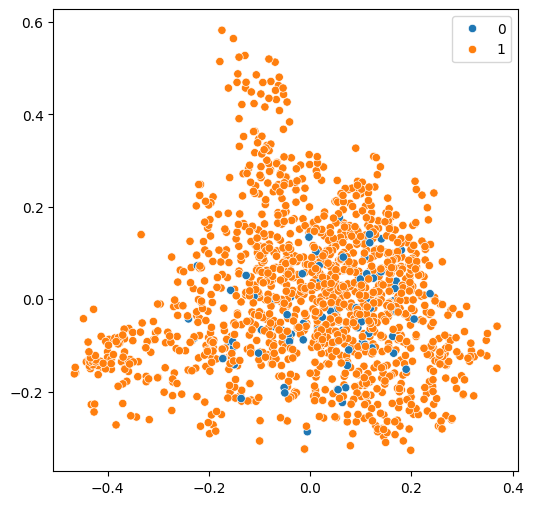

In [2]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

features = PCA(n_components=4).fit_transform(normalized_fingerprints)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [3]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, y_train)

In [4]:
train_score_c4 = svc.score(X_train, y_train)
test_score_c4 = svc.score(X_test, y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.93
Classical SVC on the test dataset:     0.95


In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel = "ibm_quantum",token = "b5a455b89bbfa812bdb28ca063b9bbd7b41da3f71ed7355b9cdd919db8bcc047a946b5d715bea68da50f6b52d248443c79a2b3e330ea878e32c773276090c189")

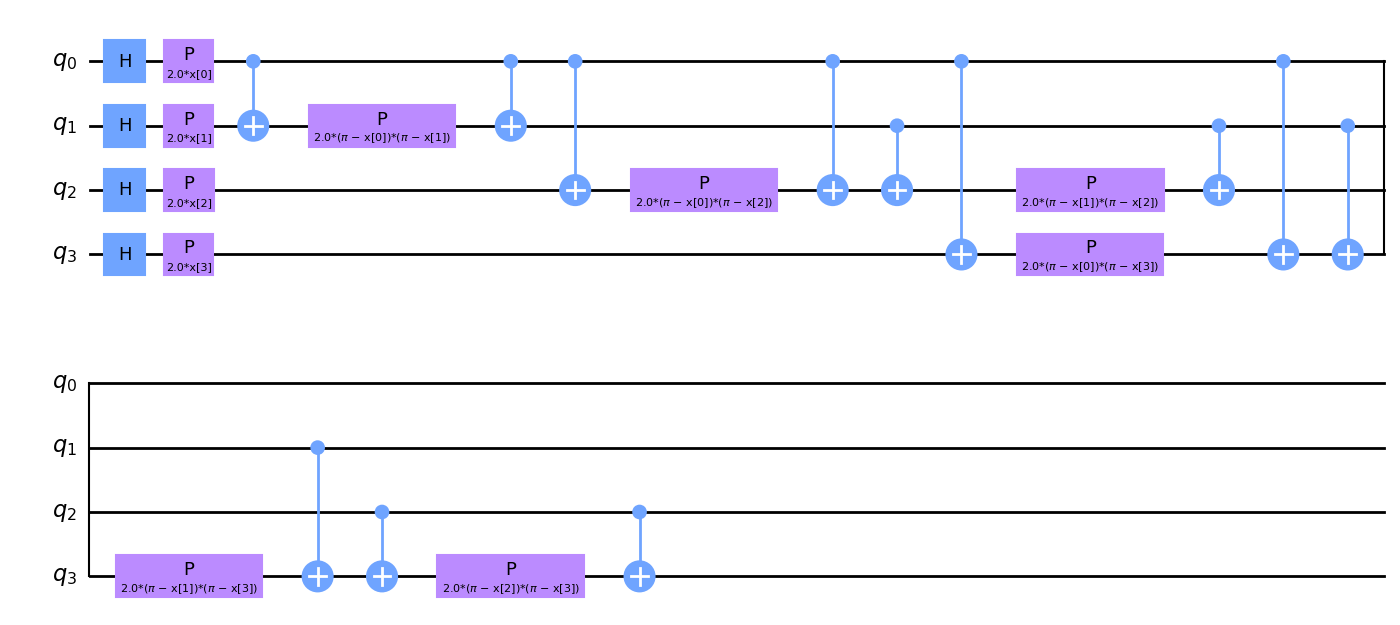

In [6]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

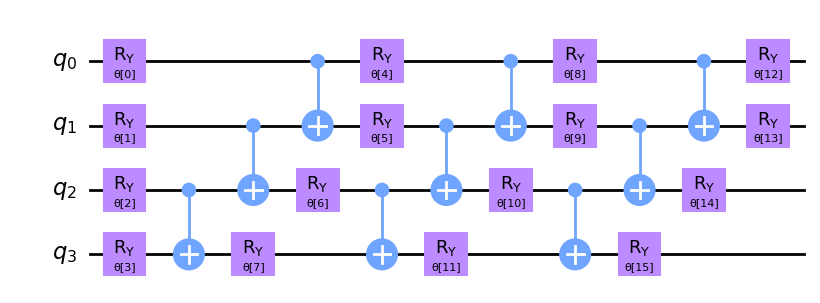

In [7]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [38]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=40)

In [39]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [40]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

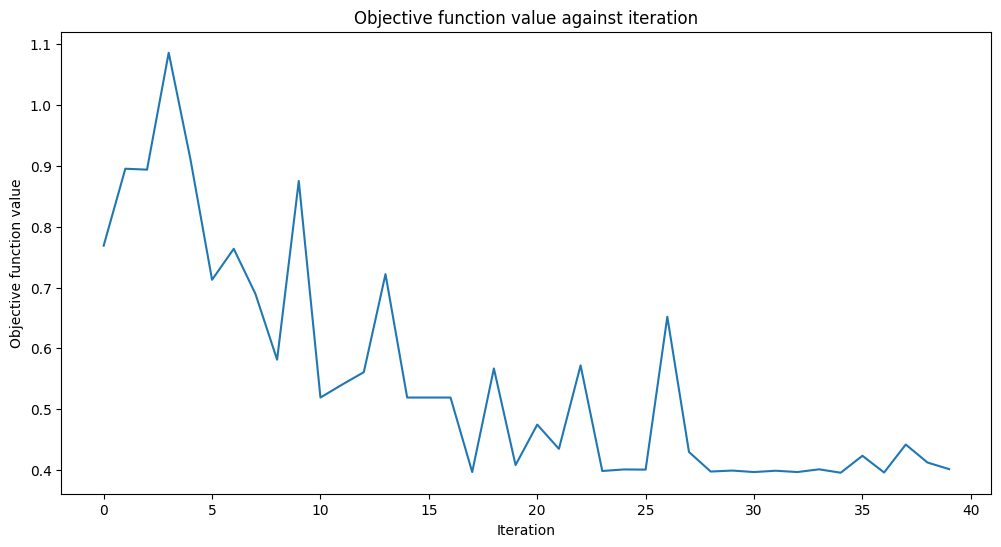

Training time: 184 seconds


In [41]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [42]:
train_score_q2_ra = vqc.score(X_train, y_train)
test_score_q2_ra = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.93
Quantum VQC on the test dataset using RealAmplitudes:     0.95


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from qiskit_aer import Aer
from qiskit import *
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.classifiers import VQC

# Load the Clintox dataset
# Note: Ensure you have the Clintox dataset available locally or access it via an appropriate method.
clintox_data = pd.read_csv('clintox.csv')  # Adjust the path to your dataset

# Extract SMILES and labels
smiles_list = clintox_data['smiles']
labels = clintox_data['FDA_APPROVED']  # Adjust the column name to match your dataset

# Function to generate Morgan fingerprints
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fingerprint)
    else:
        return None

fingerprints = [smiles_to_fingerprint(smiles) for smiles in smiles_list]

# Remove None entries resulting from invalid SMILES
valid_data = [(fp, label) for fp, label in zip(fingerprints, labels) if fp is not None]
if len(valid_data) != len(smiles_list):
    print(f"Removed {len(smiles_list) - len(valid_data)} invalid SMILES")

# Separate fingerprints and labels again
fingerprints, labels = zip(*valid_data)


# Normalize the fingerprints
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

normalized_fingerprints = [normalize_vector(fp) for fp in fingerprints]
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

features = PCA(n_components=4).fit_transform(normalized_fingerprints)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=40)
from qiskit.primitives import Sampler

sampler = Sampler()
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
train_score_q2_ra = vqc.score(X_train, y_train)
test_score_q2_ra = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")